In [2]:
import csv
import os.path
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop, Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import regularizers
from keras.layers.normalization import BatchNormalization

from rbflayer import RBFLayer, InitCentersRandom
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import *

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn import datasets, linear_model

import matplotlib.pyplot as plt
import math
import pandas as pd

c:\program files\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# loading of dataset 
dataset = []
labels = []
headers = []

def load_dataset_raw():
    global dataset, labels, headers
    with open('OnlineNewsPopularity.csv', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='|')
        headers = next(reader) # the first row
        headers = headers[1:]
        headers = [x.strip(' ') for x in headers]    
            
        temp_data = []
        temp_label = []
        for idx, row in enumerate(reader):
            temp_data.append(row[1:])
            temp_label.append(row[-1])

        # convert elements to float        
        for idx, row in enumerate(temp_data):        
            dataset.append([float(i) for i in row[:]])
        for idx, row in enumerate(temp_label):
            labels.append(float(row))   
        
    return np.array(dataset), np.array(labels).reshape(-1, 1)

def load_dataset(is_normalize=True, is_remove_outlier=True, select_top=50):
    """
    is_normalize: To normalize or keep orignal form
    is_remove_outlier: To remove outlier 
    select_top: select top important features using PCA (Principal component analysis)
    """
    global dataset, labels, headers
    with open('OnlineNewsPopularity.csv', newline='') as csvfile:
        # Defining fields to drop
        fields_to_avoid = [0, 18, 20, 24, 38, 39, 40, 41, 42]
        weekday = [30, 31, 32, 33, 34, 35, 36, 37]
        data_channel = [12, 13, 14, 15, 16, 17]
        fields_to_avoid = fields_to_avoid + weekday + data_channel
        fields_to_avoid = sorted(fields_to_avoid)
        
        reader = csv.reader(csvfile, delimiter=',', quotechar='|')
        headers = next(reader) # the first row
        headers = headers[1:]
        temp_header = []
        for idx, h in enumerate(headers):
            if idx not in fields_to_avoid:
                temp_header.append(str(h))
        headers = [x.strip(' ') for x in temp_header]
        
        temp_data = []
        temp_label = []
        
        # slicing off columns to avoid
        for idx, row in enumerate(reader):
            slice_row = [i for num,i in enumerate(row) if num not in fields_to_avoid]
            if idx in weekday and row[idx] == 1:
                if idx == 31:
                    slice_row.append(1)
                elif idx == 32:
                    slice_row.append(2)
                elif idx == 33:
                    slice_row.append(3)
                elif idx == 34:
                    slice_row.append(4)
                elif idx == 35:
                    slice_row.append(5)
                elif idx == 36:
                    slice_row.append(6)
                elif idx == 37:
                    slice_row.append(7)
            if idx in data_channel and row[idx] == 1:
                if idx == 13:
                    slice_row.append(1)
                elif idx == 14:
                    slice_row.append(2)
                elif idx == 15:
                    slice_row.append(3)
                elif idx == 16:
                    slice_row.append(4)
                elif idx == 17:
                    slice_row.append(5)
                elif idx == 18:
                    slice_row.append(6)
            temp_data.append(slice_row)
            temp_label.append(row[-1])
        
        # convert elements to float        
        for idx, row in enumerate(temp_data):        
            dataset.append([float(i) for i in row[:]])
        for idx, row in enumerate(temp_label):
            labels.append(float(row))                
    
        if is_normalize:
            # it is important which type of normalization method you use
            scaler = preprocessing.MinMaxScaler()
            dataset = scaler.fit_transform(dataset)
            # last item uses MinMaxScaler
            labels = np.array(labels).reshape(-1, 1)
            scaler = preprocessing.QuantileTransformer()
            labels = scaler.fit_transform(labels)
            print('Data is normalize')
        else:
            print('No normalize apply')        
            
        if is_remove_outlier:
            dataset, labels = reject_outliers(dataset, labels)    
            
        if 0 < select_top < len(dataset):            
            top_features = pca_important_features(dataset, headers, top=select_top)
            feature_keys = [f[1] for f in top_features]
            df = pd.DataFrame(dataset, columns=headers)
            top_dataset = []
            for name in feature_keys:
                top_dataset.append(df.loc[:, name])
            dataset = np.transpose(top_dataset)
    return np.array(dataset), np.array(labels).reshape(-1, 1)

def pca_important_features(dataset, headers, top=10):
    scaleFeatures = True
    pca = PCA(n_components=top)
    projected  = pca.fit_transform(dataset)
    top_features = extract_features(projected, pca.components_, headers, top)
    return top_features
    
def extract_features(transformed_features, components_, columns, top):
    num_columns = len(columns)

    # This funtion will project your *original* feature (columns)
    # onto your principal component feature-space, so that you can
    # visualize how "important" each one was in the
    # multi-dimensional scaling

    # Scale the principal components by the max value in
    # the transformed set belonging to that component
    xvector = components_[0] * max(transformed_features[:,0])
    yvector = components_[1] * max(transformed_features[:,1])

    # Sort each column by it's length. These are your *original*
    # columns, not the principal components.
    important_features = { columns[i] : math.sqrt(xvector[i]**2 + yvector[i]**2) for i in range(num_columns) }
    important_features = sorted(zip(important_features.values(), important_features.keys()), reverse=True)
    print("Features by top {0} importance:".format(top))
    for feature in important_features[:top]:
        print(feature)
    print()
    return important_features[:top]
        
def reject_outliers(dataset, labels, m=50):        
    """
    Higher the value 'm' more outliers
    """
    d = np.abs(labels - np.median(labels))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
        
    # remove outliers in dataset and labels
    sub_dataset = []
    sub_labels = []
    outlier_labels = []
    for idx, item in enumerate(s):        
        if item < m:
            sub_labels.append(labels[idx])
            sub_dataset.append(dataset[idx])        
        else:
            outlier_labels.append(labels[idx])
    print('Outlier removed: {0}'.format(len(outlier_labels)))
    return sub_dataset, sub_labels

In [4]:
# Splitting of dataset into train and test
dataset = []
labels = []
dataset, labels = load_dataset_raw()
print('Dataset shape: {0}, Labels: {1}'.format(dataset.shape, labels.shape))

x_train, x_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, shuffle=False, random_state=42)
print("x_train: {0}, y_train: {1}".format(x_train.shape, y_train.shape))
print("x_test: {0}, y_test: {1}".format(x_test.shape, y_test.shape))

df = pd.DataFrame(np.array(dataset), columns=headers)

Dataset shape: (39644, 60), Labels: (39644, 1)
x_train: (31715, 60), y_train: (31715, 1)
x_test: (7929, 60), y_test: (7929, 1)


### Quick visualise of fields in dataset

In [5]:
df.head()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593.0
1,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711.0
2,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500.0
3,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200.0
4,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505.0


Our data set contains 30 000 instances; each consists of 60 attributes and one dependent variable, the number of shares of the article.<br>

The following variables can be omitted:<br>

__url:__ URL of the article (non-predictive)<br>
__timedelta:__ Days between the article publication and the dataset acquisition (non-predictive)<br>
__five LDA__: Latent Dirichlet allocation variables, not useful because we do not know which topic it refers to<br>
__is_weekend:__ Since it seems to be duplicating days of week<br>
__kw_min_min, kw_avg_min, kw_min_avg__: Have a number of negative values<br>

Variables which take values either 0 or 1 do not suffer of the last transformation, but we need to convert them to categorical.<br>
__weekday_is_monday<br>
weekday_is_tuesday<br>
weekday_is_wednesday<br>
weekday_is_thursday<br>
weekday_is_friday<br>
weekday_is_saturday<br>
weekday_is_sunday<br>
data_channel_is_lifestyle<br>
data_channel_is_entertainment<br>
data_channel_is_bus<br>
data_channel_is_socmed<br>
data_channel_is_tech<br>
data_channel_is_world<br>__

__Reference material:__<br>
https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/8122459673715921/932976993320889/2531719484635850/latest.html<br>


Let's take a look at these fields

In [6]:
fields_to_avoid = [0, 9, 18, 20, 24, 38, 39, 40, 41, 42]
weekday = [30, 31, 32, 33, 34, 35, 36, 37]
data_channel = [12, 13, 14, 15, 16, 17]
fields_to_avoid = fields_to_avoid + weekday + data_channel
fields_to_avoid = sorted(fields_to_avoid)

subset_headers = []
for idx, h in enumerate(headers):
    if idx in fields_to_avoid:
        subset_headers.append(h)
print(subset_headers)
df.loc[:10, subset_headers]

['timedelta', 'num_videos', 'data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world', 'kw_min_min', 'kw_avg_min', 'kw_min_avg', 'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04']


,timedelta,num_videos,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_avg_min,...,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04
0,731.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.500331,0.378279,0.040005,0.041263,0.040123
1,731.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.799756,0.050047,0.050096,0.050101,0.050001
2,731.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.217792,0.033334,0.033351,0.033334,0.682188
3,731.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.028573,0.419300,0.494651,0.028905,0.028572
4,731.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.028633,0.028794,0.028575,0.028572,0.885427
5,731.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.022245,0.306718,0.022231,0.022224,0.626582
6,731.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.020082,0.114705,0.020024,0.020015,0.825173
7,731.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.022224,0.150733,0.243435,0.022224,0.561384
8,731.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.458250,0.028979,0.028662,0.029696,0.454412
9,731.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.040000,0.040000,0.839997,0.040001,0.040002


### Converting to categorical
Changing weekdays and data channel to categorical. Notice there are some data that doesn't fall in any of the data channel, we will append 0 to these datasets.

In [7]:
sub_headers = []
for idx, h in enumerate(headers):
    if idx not in fields_to_avoid:
        sub_headers.append(h)
        
# weekday = [30, 31, 32, 33, 34, 35, 36, 37]
# data_channel = [12, 13, 14, 15, 16, 17]

sub_headers.insert(len(sub_headers) - 1, 'weekday')
sub_headers.insert(len(sub_headers) - 1, 'data_channel')

print('headers length: {0}'.format(len(sub_headers)))
print(sub_headers)

new_dataset = []        
for idx, row in enumerate(dataset):
    slice_row = [i for num,i in enumerate(row) if num not in fields_to_avoid]
    insert_idx = len(slice_row) - 1
    
    for col_idx in range(len(row)):
        # convert week day to categorical 
        if col_idx in weekday and row[col_idx] == 1:
            if col_idx == 30:
                slice_row.insert(insert_idx, 1)
            elif col_idx == 31:
                slice_row.insert(insert_idx, 2)
            elif col_idx == 32:
                slice_row.insert(insert_idx, 3)
            elif col_idx == 33:
                slice_row.insert(insert_idx, 4)
            elif col_idx == 34:
                slice_row.insert(insert_idx, 5)
            elif col_idx == 35:
                slice_row.insert(insert_idx, 6)
            elif col_idx == 36:
                slice_row.insert(insert_idx, 7)

        # convert data channel to categorical 
        if col_idx in data_channel and row[col_idx] == 1:
            if col_idx == 12:
                slice_row.insert(insert_idx, 1)
            elif col_idx == 13:
                slice_row.insert(insert_idx, 2)
            elif col_idx == 14:
                slice_row.insert(insert_idx, 3)
            elif col_idx == 15:
                slice_row.insert(insert_idx, 4)
            elif col_idx == 16:
                slice_row.insert(insert_idx, 5)
            elif col_idx == 17:
                slice_row.insert(insert_idx, 6)
   
    # handle missing data
    if len(slice_row) == 38:
        slice_row.append(0)
    new_dataset.append(slice_row)

new_dataset = np.array(new_dataset)
print()
print(new_dataset.shape)
print(new_dataset[0])

headers length: 38
['n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'num_imgs', 'average_token_length', 'num_keywords', 'kw_max_min', 'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess', 'global_subjectivity', 'global_sentiment_polarity', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity', 'min_positive_polarity', 'max_positive_polarity', 'avg_negative_polarity', 'min_negative_polarity', 'max_negative_polarity', 'title_subjectivity', 'title_sentiment_polarity', 'abs_title_subjectivity', 'abs_title_sentiment_polarity', 'weekday', 'data_channel', 'shares']

(39644,)
[12.0, 219.0, 0.663594466988, 0.999999992308, 0.815384609112, 4.0, 2.0, 1.0, 4.6803652968, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 496.0, 496.0, 496.0, 0.52161714

### Viewing at our target
Let's take a look at our target __Shares__, we can see that there alot of outliers in this field. We will be removing the outliers by normalise the data. 

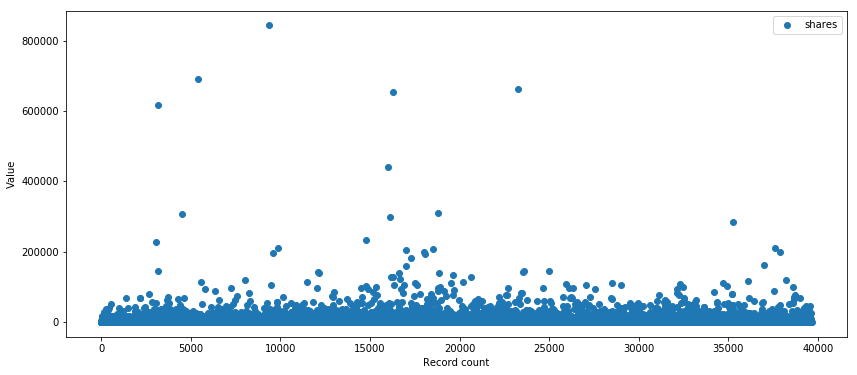

In [8]:
def show_graph(data):
    plt.figure(figsize=(14,6))
    plt.xlabel("Record count")
    plt.ylabel("Value")
    plt.title("")
    x = list(range(len(data)))
    plt.scatter(x, [pt[0] for pt in data], label='shares')
    plt.legend(loc='upper right')
    plt.show()

# before removing outliers
show_graph(labels)

Data is normalize
Outlier removed: 0


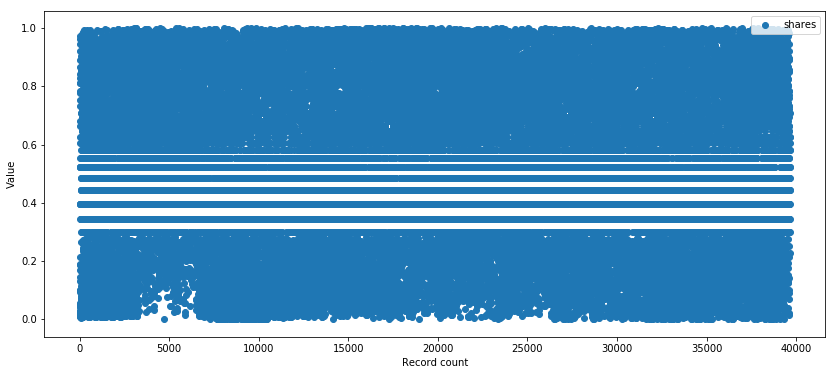

In [9]:
# after removing outliers
dataset = []
labels = []
dataset, labels = load_dataset(is_normalize=True, is_remove_outlier=True, select_top=-1)
show_graph(labels)